###Exercise 1.0: Set up and first Train

#### PIP

In [ ]:
!pip install wandb
!pip install datasets==2.16.0
!pip install huggingface-hub==0.20.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Foun

#### Imports

In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models.resnet import BasicBlock
import torchvision.models as models
from tqdm import tqdm
import math
import time
import random
import warnings
import io
import wandb
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from torch.utils.data import Dataset # Import Dataset
import cv2

#### Set WANDB

In [ ]:
def setup_wandb(project_name="DLA-LAB_1", run_name=None):
    run = wandb.init(project=project_name,
                     name=run_name,
                     config={
                         "architecture": "Various Nets",
                         "task": "DLA-LAB_1",
                         "dataset": "//"
                     })

    return run

def login_in_wandb():
  wandb.login(key="yourkey")
  print("Logged to wnadb!")


def save_model_to_wandb(model, model_name, run=None):
    local_path = f"{model_name}"
    torch.save(model.state_dict(), local_path)

    if run is None:
        if wandb.run is None:
            print("Nessuna sessione wandb attiva. Il modello è stato salvato solo localmente.")
            return local_path
        run = wandb.run

    artifact = wandb.Artifact(
        name=model_name,
        type="model"
        # description=f"Modello addestrato sul task di {model_name.split('_')[0]}"
    )
    artifact.add_file(local_path)
    run.log_artifact(artifact)

    print(f"Modello salvato su wandb come {model_name}")
    return local_path

In [ ]:
login_in_wandb()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mencucci-marco (mencucci-marco-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged to wnadb!


#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#dataloaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)
print("Data loaded")

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.25MB/s]

Data loaded


#### My Train Routine

In [ ]:
def train_wandb(net, criterion, optimizer, scheduler, num_epochs, device,
                               trainloader, valloader, early_stopping,
                               patience, delta, use_wandb=True):
    accuracy_train, loss_train = [], []
    accuracy_val, loss_val = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        net.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        epoch_loss, epoch_correct, epoch_total = 0.0, 0, 0
        start_time = time.time()

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = outputs.argmax(dim=1)

            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            epoch_loss += loss.item() * labels.size(0)
            epoch_total += labels.size(0)
            epoch_correct += (predicted == labels).sum().item()

            if i % 25 == 24:
                batch_loss = running_loss / 25
                batch_acc = 100 * running_correct / running_total
                batch_time = time.time() - start_time

                print(f'[Epoch {epoch+1}, Batch {i+1}] loss: {batch_loss:.3f} acc: {batch_acc:.2f} time: {batch_time:.2f}')

                if use_wandb:
                    wandb.log({
                        "batch": epoch * len(trainloader) + i,
                        "batch_loss": batch_loss,
                        "batch_accuracy": batch_acc,
                        "batch_time": batch_time
                    })

                running_loss, running_correct, running_total = 0.0, 0, 0
                start_time = time.time()

        # Epoch metrics
        epoch_loss /= epoch_total
        epoch_acc = 100 * epoch_correct / epoch_total

        net.eval()
        return_report = False
        val_loss, val_acc = evaluate_classification(net, valloader, criterion, device, return_report)

        accuracy_train.append(epoch_acc)
        loss_train.append(epoch_loss)
        accuracy_val.append(val_acc)
        loss_val.append(val_loss)

        if use_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": epoch_loss,
                "train_accuracy": epoch_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        if scheduler is not None:
          # scheduler.step()
          scheduler.step(val_loss)

        # Early stopping
        if early_stopping:
            if val_loss < best_val_loss - delta:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = net.state_dict()
            else:
                epochs_no_improve += 1
                print(f"→ No improvement for {epochs_no_improve} epoch(s)")
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    if best_model_state:
                        net.load_state_dict(best_model_state)
                    break

    print('Finished Training')
    return accuracy_train, loss_train

def evaluate_classification(net, dataloader, criterion, device, return_report):
    net.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = total_loss / total
    avg_acc = 100 * correct / total
    if return_report:
        report = classification_report(all_labels, all_preds, digits=3)
        return avg_loss, avg_acc, report
    return avg_loss, avg_acc

#### FIRST MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
class oldMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### First Train for MLP
In this part we will train a simple MLP

In [ ]:
input_size = 28*28

In [ ]:
# Training hyperparameters.
login_in_wandb()
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.0001
early_stopping = False
patience = 5
delta = 0.001

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2


# Instantiate model and optimizer.
model_mlp = oldMLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# wandb run initialization
run = setup_wandb(project_name="DLA-LAB_1", run_name="INTRO_EXPERIMENT")
accuracy_train, loss_train = train_wandb(model_mlp, criterion, opt, None, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mencucci-marco (mencucci-marco-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged to wnadb!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1, Batch 25] loss: 2.270 acc: 14.80 time: 1.63
[Epoch 1, Batch 50] loss: 2.222 acc: 23.20 time: 1.23
[Epoch 1, Batch 75] loss: 2.168 acc: 27.30 time: 1.06
[Epoch 1, Batch 100] loss: 2.104 acc: 35.81 time: 1.11
[Epoch 1, Batch 125] loss: 2.019 acc: 47.98 time: 0.93
[Epoch 1, Batch 150] loss: 1.940 acc: 55.09 time: 1.15
[Epoch 1, Batch 175] loss: 1.845 acc: 61.08 time: 1.08
[Epoch 1, Batch 200] loss: 1.732 acc: 63.50 time: 1.50
Epoch 1/20 | Train Loss: 2.0113 | Train Acc: 42.70% | Val Loss: 1.6289 | Val Acc: 64.60%
[Epoch 2, Batch 25] loss: 1.581 acc: 64.73 time: 1.36
[Epoch 2, Batch 50] loss: 1.498 acc: 66.06 time: 1.05
[Epoch 2, Batch 75] loss: 1.411 acc: 68.61 time: 1.03
[Epoch 2, Batch 100] loss: 1.324 acc: 71.05 time: 1.13
[Epoch 2, Batch 125] loss: 1.241 acc: 72.06 time: 1.13
[Epoch 2, Batch 150] loss: 1.179 acc: 73.91 time: 1.04
[Epoch 2, Batch 175] loss: 1.125 acc: 74.61 time: 1.15
[Epoch 2, Batch 200] loss: 1.067 acc: 75.16 time: 1.06
Epoch 2/20 | Train Loss: 1.2829 | Tra

batch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
batch_accuracy,▁▃▄▅▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
batch_loss,█▆▆▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_time,▁▃▃▂▂▂▁▁▃▁▃▅▃▂▄▁▂▄▂▂▃▁▆▂▂▁▂▁▁▂▆▁▂▄▄█▇▁▂▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▆▇▇▇▇█████████████
train_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇██████████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch,4284


In [ ]:
accuracy_test, loss_test, report = evaluate_classification(model_mlp, test_loader, criterion, device, return_report=True)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0      0.923     0.985     0.953       980
           1      0.963     0.974     0.968      1135
           2      0.925     0.912     0.918      1032
           3      0.904     0.909     0.906      1010
           4      0.916     0.939     0.927       982
           5      0.892     0.861     0.876       892
           6      0.943     0.939     0.941       958
           7      0.933     0.911     0.922      1028
           8      0.895     0.872     0.883       974
           9      0.911     0.902     0.906      1009

    accuracy                          0.921     10000
   macro avg      0.920     0.920     0.920     10000
weighted avg      0.921     0.921     0.921     10000



### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

Let's first inspect my parameterized MLP created using a ModuleList. Note that it contains a single submodule called `layers`:

#### MLP model

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super().__init__()
        layers = []
        # First layer : input_size -> hidd size
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        # hidden layers
        for _ in range(num_hidden_layers - 1):
          layers.append(nn.Linear(hidden_size, hidden_size))
          layers.append(nn.ReLU())
        # Last layer: number of labels (output_size)
        layers.append(nn.Linear(hidden_size, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

input_size_mnist = 28*28
output_size_mnist = 10

model = MLP(input_size_mnist, 32, 2, output_size_mnist)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


Let's try the first MLP that is super-simple

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.0001
early_stopping = False
patience = 5
delta = 0.001

model_mlp = model.to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# wandb run initialization
run = setup_wandb(project_name="DLA-LAB_1", run_name="MLP_experiment")
accuracy_train, loss_train = train_wandb(model_mlp, criterion, opt, None, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
run.finish()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1, Batch 25] loss: 2.284 acc: 17.02 time: 1.41
[Epoch 1, Batch 50] loss: 2.206 acc: 27.19 time: 1.11
[Epoch 1, Batch 75] loss: 2.072 acc: 36.69 time: 1.04
[Epoch 1, Batch 100] loss: 1.935 acc: 38.91 time: 1.89
[Epoch 1, Batch 125] loss: 1.797 acc: 42.83 time: 1.64
[Epoch 1, Batch 150] loss: 1.645 acc: 50.67 time: 1.18
[Epoch 1, Batch 175] loss: 1.478 acc: 61.19 time: 1.06
[Epoch 1, Batch 200] loss: 1.341 acc: 66.53 time: 1.20
Epoch 1/20 | Train Loss: 1.8034 | Train Acc: 44.49% | Val Loss: 1.1879 | Val Acc: 71.74%
[Epoch 2, Batch 25] loss: 1.128 acc: 74.47 time: 1.34
[Epoch 2, Batch 50] loss: 1.027 acc: 76.92 time: 1.21
[Epoch 2, Batch 75] loss: 0.938 acc: 79.00 time: 1.19
[Epoch 2, Batch 100] loss: 0.865 acc: 80.58 time: 1.14
[Epoch 2, Batch 125] loss: 0.784 acc: 82.28 time: 1.69
[Epoch 2, Batch 150] loss: 0.732 acc: 82.94 time: 1.80
[Epoch 2, Batch 175] loss: 0.699 acc: 83.30 time: 1.06
[Epoch 2, Batch 200] loss: 0.654 acc: 84.67 time: 1.13
Epoch 2/20 | Train Loss: 0.8371 | Tra

batch,▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
batch_accuracy,▁▃▄▅▇▇▇▇▇▇██████████████████████████████
batch_loss,██▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_time,▄▁▇▃▄▂▂▂▁▆▂▂▁▂█▃▃▁▁▂▁▄▁▂▆▁▄▂▅▂▂▁█▆▂▆▃▄▁▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▆▇▇▇▇██████████████
train_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇▇▇▇█████████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch,4284


In [ ]:
accuracy_test, loss_test, report = evaluate_classification(model_mlp, test_loader, criterion, device, return_report=True)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0      0.955     0.981     0.968       980
           1      0.971     0.975     0.973      1135
           2      0.947     0.937     0.942      1032
           3      0.926     0.931     0.928      1010
           4      0.937     0.949     0.943       982
           5      0.933     0.913     0.923       892
           6      0.947     0.961     0.954       958
           7      0.963     0.930     0.946      1028
           8      0.911     0.921     0.916       974
           9      0.931     0.923     0.927      1009

    accuracy                          0.943     10000
   macro avg      0.942     0.942     0.942     10000
weighted avg      0.943     0.943     0.943     10000



#### Gradient Magnitude



In [ ]:
def gradient_magnitudes_plot(model, num_layers):
  # extraction gradients of bias
  biases = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 1]

  # extraction gradeients of weights
  weights = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 2]

  # Plot the norms of the biases.
  plt.plot([(p * p).sum().sqrt().item() for p in biases]) #L2 norm of biases' gradients
  plt.plot([(p * p).sum().sqrt().item() for p in weights]) #L2 norm of weights' gradients
  plt.xlabel('Layer')
  plt.ylabel('$||\\nabla_p \\mathcal{L}||$')
  plt.legend(['Biases', 'Weight Matrices'])
  plt.title(f'MLP {num_layers} Layers Gradient Norm Analysis')
  plt.show()


=== Training MLP with 10 hidden layers ===


[Epoch 1, Batch 25] loss: 2.308 acc: 10.42 time: 0.54
[Epoch 1, Batch 50] loss: 2.308 acc: 10.20 time: 0.43
[Epoch 1, Batch 75] loss: 2.305 acc: 10.34 time: 0.37
[Epoch 1, Batch 100] loss: 2.306 acc: 17.53 time: 0.39
[Epoch 1, Batch 125] loss: 2.304 acc: 18.52 time: 0.40
[Epoch 1, Batch 150] loss: 2.302 acc: 18.69 time: 0.43
[Epoch 1, Batch 175] loss: 2.295 acc: 18.55 time: 0.38
[Epoch 1, Batch 200] loss: 2.279 acc: 19.20 time: 0.40
Epoch 1/20 | Train Loss: 2.2975 | Train Acc: 15.99% | Val Loss: 2.2301 | Val Acc: 22.58%
[Epoch 2, Batch 25] loss: 2.182 acc: 21.08 time: 0.53
[Epoch 2, Batch 50] loss: 2.051 acc: 20.38 time: 0.44
[Epoch 2, Batch 75] loss: 1.941 acc: 22.34 time: 0.35
[Epoch 2, Batch 100] loss: 1.844 acc: 26.81 time: 0.38
[Epoch 2, Batch 125] loss: 1.721 acc: 33.34 time: 0.38
[Epoch 2, Batch 150] loss: 1.614 acc: 39.00 time: 0.39
[Epoch 2, Batch 175] loss: 1.502 acc: 44.62 time: 0.39
[Epoch 2, Batch 200] loss: 1.411 acc: 48.98 time: 0.42
Epoch 2/20 | Train Loss: 1.7505 | Tra

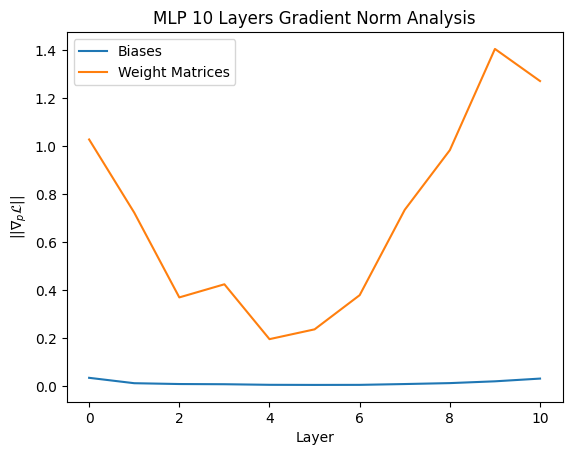

batch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
batch_accuracy,▁▂▂▂▂▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
batch_loss,█████▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch_time,▂▆▁▂▂▃▃▇▄▆▂▂█▃▃▅▆▅▂▃▃▂▃▂▁▆▂▃▁▆▃▃▁▂▂▁█▃▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▆▇▇▇▇▇███████████
train_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇███████████
val_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch,4284



=== Training MLP with 20 hidden layers ===


[Epoch 1, Batch 25] loss: 2.312 acc: 9.88 time: 0.52
[Epoch 1, Batch 50] loss: 2.310 acc: 10.30 time: 0.42
[Epoch 1, Batch 75] loss: 2.311 acc: 9.34 time: 0.37
[Epoch 1, Batch 100] loss: 2.310 acc: 9.55 time: 0.37
[Epoch 1, Batch 125] loss: 2.305 acc: 11.08 time: 0.41
[Epoch 1, Batch 150] loss: 2.309 acc: 9.41 time: 0.41
[Epoch 1, Batch 175] loss: 2.306 acc: 10.78 time: 0.40
[Epoch 1, Batch 200] loss: 2.307 acc: 9.64 time: 0.37
Epoch 1/20 | Train Loss: 2.3086 | Train Acc: 9.93% | Val Loss: 2.3068 | Val Acc: 9.72%
[Epoch 2, Batch 25] loss: 2.306 acc: 9.81 time: 0.50
[Epoch 2, Batch 50] loss: 2.307 acc: 9.83 time: 0.35
[Epoch 2, Batch 75] loss: 2.305 acc: 9.86 time: 0.40
[Epoch 2, Batch 100] loss: 2.305 acc: 10.05 time: 0.37
[Epoch 2, Batch 125] loss: 2.303 acc: 9.53 time: 0.40
[Epoch 2, Batch 150] loss: 2.302 acc: 11.08 time: 0.47
[Epoch 2, Batch 175] loss: 2.303 acc: 9.69 time: 0.35
[Epoch 2, Batch 200] loss: 2.304 acc: 10.05 time: 0.45
Epoch 2/20 | Train Loss: 2.3041 | Train Acc: 10.0

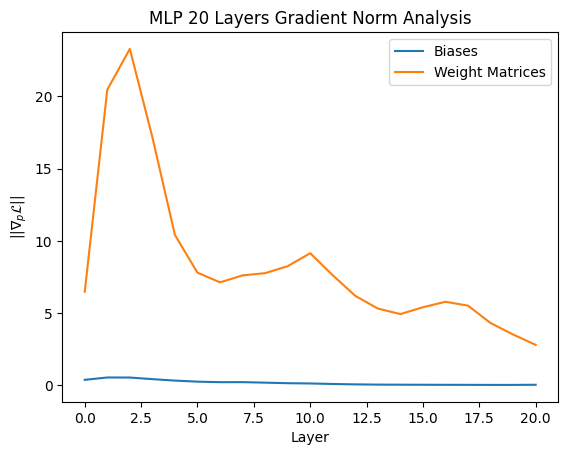

batch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch_accuracy,▁▁▁▁▁▂▂▂▂▃▆▆▆▆▆▇▇▇▇▇▇█▇█▇███████████████
batch_loss,███▇▇▇▇▆▆▆▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
batch_time,▃▁▃▆▁▁▃▁▁▂▄▄█▂▃▃▂▃▃▃▃▄▃▃▂▂▃▇▂▁▃▄▁▁▁▂█▃▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▂▃▅▆▆▇▇▇▇████████
train_loss,██▇▆▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▅▆▆▆▇▇▇▇████████
val_loss,██▇▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
batch,4284



=== Training MLP with 30 hidden layers ===


[Epoch 1, Batch 25] loss: 2.307 acc: 10.27 time: 0.55
[Epoch 1, Batch 50] loss: 2.306 acc: 9.75 time: 0.41
[Epoch 1, Batch 75] loss: 2.306 acc: 9.98 time: 0.36
[Epoch 1, Batch 100] loss: 2.303 acc: 10.03 time: 0.44
[Epoch 1, Batch 125] loss: 2.305 acc: 9.83 time: 0.38
[Epoch 1, Batch 150] loss: 2.304 acc: 10.50 time: 0.37
[Epoch 1, Batch 175] loss: 2.305 acc: 9.69 time: 0.39
[Epoch 1, Batch 200] loss: 2.304 acc: 9.95 time: 0.42
Epoch 1/20 | Train Loss: 2.3049 | Train Acc: 9.93% | Val Loss: 2.3034 | Val Acc: 9.72%
[Epoch 2, Batch 25] loss: 2.303 acc: 10.17 time: 0.56
[Epoch 2, Batch 50] loss: 2.304 acc: 9.84 time: 0.41
[Epoch 2, Batch 75] loss: 2.303 acc: 10.27 time: 0.42
[Epoch 2, Batch 100] loss: 2.303 acc: 9.95 time: 0.40
[Epoch 2, Batch 125] loss: 2.304 acc: 9.69 time: 0.34
[Epoch 2, Batch 150] loss: 2.303 acc: 10.23 time: 0.38
[Epoch 2, Batch 175] loss: 2.302 acc: 9.94 time: 0.36
[Epoch 2, Batch 200] loss: 2.303 acc: 9.55 time: 0.36
Epoch 2/20 | Train Loss: 2.3031 | Train Acc: 9.93

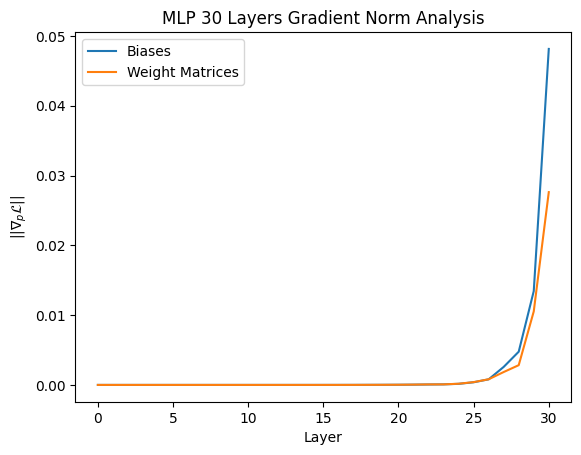

batch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
batch_accuracy,▂▂▄▃▂▂▁▂▃▅▄▅▆▆▇▇█▄▇▇▆▇▅▅▄▆▅▇▅▅▆▅▆▇▆▅▃▆▆▅
batch_loss,█▇▅▄▅▂▃▁▂▂▂▂▁▂▃▂▁▂▂▂▂▂▂▂▂▂▃▂▂▂▃▃▂▂▂▂▂▃▂▂
batch_time,▇▁▇▃▂▂▁▆▂▁▁▂▂▁▄▃▂█▂▁▃▁▂▂▂▃▁▁▂▁▁▁▃▇▂▂▁▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▃█████████████████
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁██████████████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,4284


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
hidden_layers_list = [10, 20, 30]
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.0001
early_stopping = False
patience = 5
delta = 0.001
report_list = []

for num_hidden in hidden_layers_list:
    print(f"\n=== Training MLP with {num_hidden} hidden layers ===")
    model = MLP(input_size_mnist, 32, num_hidden, output_size_mnist)
    model = model.to(device)

    opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    run = setup_wandb(project_name="DLA-LAB_1", run_name=f"MLP_{num_hidden}_layers")

    # Training
    accuracy_train, loss_train = train_wandb(
        model, criterion, opt, None, epochs, device,
        train_loader, validation_loader,
        early_stopping, patience, delta
    )

    gradient_magnitudes_plot(model, num_hidden)

    run.finish()
    accuracy_test, loss_test, report = evaluate_classification(model, test_loader, criterion, device, return_report=True)
    report_list.append(report)

In [ ]:
for i in range(len(hidden_layers_list)):
  num_hidden = hidden_layers_list[i]
  report = report_list[i]
  print(f"Report of MLP with {num_hidden} layers")
  print("")
  print(report)
  print("")

Report of MLP with 10 layers

              precision    recall  f1-score   support

           0      0.969     0.961     0.965       980
           1      0.958     0.953     0.955      1135
           2      0.950     0.842     0.893      1032
           3      0.901     0.865     0.883      1010
           4      0.918     0.901     0.910       982
           5      0.826     0.833     0.829       892
           6      0.933     0.933     0.933       958
           7      0.909     0.878     0.894      1028
           8      0.817     0.890     0.852       974
           9      0.794     0.895     0.842      1009

    accuracy                          0.896     10000
   macro avg      0.897     0.895     0.896     10000
weighted avg      0.899     0.896     0.897     10000


Report of MLP with 20 layers

              precision    recall  f1-score   support

           0      0.760     0.896     0.822       980
           1      0.989     0.967     0.978      1135
           2     

Vanishing gradients!!

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size, hidden_size)
    #use only one linear layer
    def forward(self, x):
        return F.relu(self.linear(x) + x)


class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super().__init__()

        layers = []

        # avoiding errors in num hidden layers is zero
        if num_hidden_layers == 0:
            layers.append(nn.Linear(input_size, output_size))
            self.net = nn.Sequential(*layers)
            return

        # first layer input -> hidd
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # num_hidden_layers = num di residual blocks
        # max to avoid problems if num_hidden_layers is zero
        for _ in range(max(0, num_hidden_layers - 1)):
            layers.append(ResidualBlock(hidden_size))

        # last layer: hidden -> output
        layers.append(nn.Linear(hidden_size, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)



=== Training MLP with 10 hidden layers ===


[Epoch 1, Batch 25] loss: 2.283 acc: 12.92 time: 0.56
[Epoch 1, Batch 50] loss: 2.046 acc: 26.66 time: 0.41
[Epoch 1, Batch 75] loss: 1.679 acc: 48.98 time: 0.37
[Epoch 1, Batch 100] loss: 1.298 acc: 63.42 time: 0.42
[Epoch 1, Batch 125] loss: 0.948 acc: 73.95 time: 0.40
[Epoch 1, Batch 150] loss: 0.708 acc: 80.23 time: 0.37
[Epoch 1, Batch 175] loss: 0.590 acc: 82.75 time: 0.36
[Epoch 1, Batch 200] loss: 0.502 acc: 85.64 time: 0.41
Epoch 1/20 | Train Loss: 1.2022 | Train Acc: 61.21% | Val Loss: 0.4424 | Val Acc: 86.78%
[Epoch 2, Batch 25] loss: 0.427 acc: 87.84 time: 0.51
[Epoch 2, Batch 50] loss: 0.378 acc: 89.16 time: 0.40
[Epoch 2, Batch 75] loss: 0.382 acc: 88.92 time: 0.43
[Epoch 2, Batch 100] loss: 0.360 acc: 89.88 time: 0.38
[Epoch 2, Batch 125] loss: 0.357 acc: 89.64 time: 0.40
[Epoch 2, Batch 150] loss: 0.362 acc: 89.47 time: 0.38
[Epoch 2, Batch 175] loss: 0.332 acc: 90.64 time: 0.43
[Epoch 2, Batch 200] loss: 0.302 acc: 91.09 time: 0.40
Epoch 2/20 | Train Loss: 0.3601 | Tra

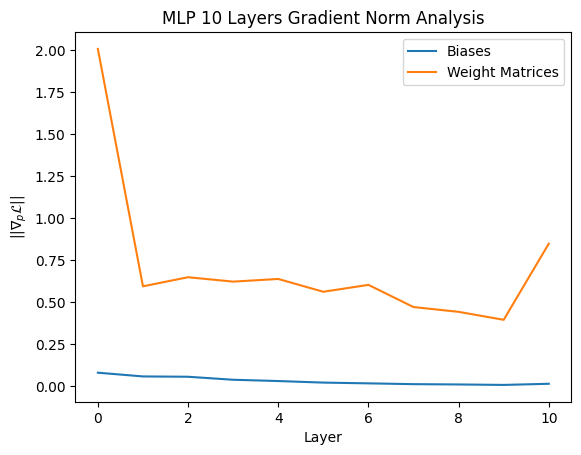

batch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
batch_accuracy,▁▅▆▆▇▇▇▇▇███████████████████████████████
batch_loss,█▇▇▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁
batch_time,▃▂▂▂▂▂▃▂▁▃▃▂▃▂▆▃▄▁▃▂▃▅▁▁██▂▁▇▁▃▃▃▂▁▂▂▁▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▇▇▇▇██████████████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
batch,4284



=== Training MLP with 20 hidden layers ===


[Epoch 1, Batch 25] loss: 3.001 acc: 10.53 time: 0.61
[Epoch 1, Batch 50] loss: 2.333 acc: 10.14 time: 0.36
[Epoch 1, Batch 75] loss: 2.246 acc: 10.89 time: 0.39
[Epoch 1, Batch 100] loss: 2.168 acc: 18.09 time: 0.42
[Epoch 1, Batch 125] loss: 2.007 acc: 33.89 time: 0.41
[Epoch 1, Batch 150] loss: 1.770 acc: 44.81 time: 0.41
[Epoch 1, Batch 175] loss: 1.470 acc: 51.55 time: 0.36
[Epoch 1, Batch 200] loss: 1.140 acc: 59.52 time: 0.36
Epoch 1/20 | Train Loss: 1.9431 | Train Acc: 32.63% | Val Loss: 0.8640 | Val Acc: 74.44%
[Epoch 2, Batch 25] loss: 0.819 acc: 76.88 time: 0.54
[Epoch 2, Batch 50] loss: 0.656 acc: 80.77 time: 0.47
[Epoch 2, Batch 75] loss: 0.596 acc: 82.28 time: 0.48
[Epoch 2, Batch 100] loss: 0.522 acc: 84.48 time: 0.41
[Epoch 2, Batch 125] loss: 0.476 acc: 85.83 time: 0.42
[Epoch 2, Batch 150] loss: 0.461 acc: 86.23 time: 0.40
[Epoch 2, Batch 175] loss: 0.432 acc: 87.00 time: 0.39
[Epoch 2, Batch 200] loss: 0.406 acc: 88.09 time: 0.36
Epoch 2/20 | Train Loss: 0.5354 | Tra

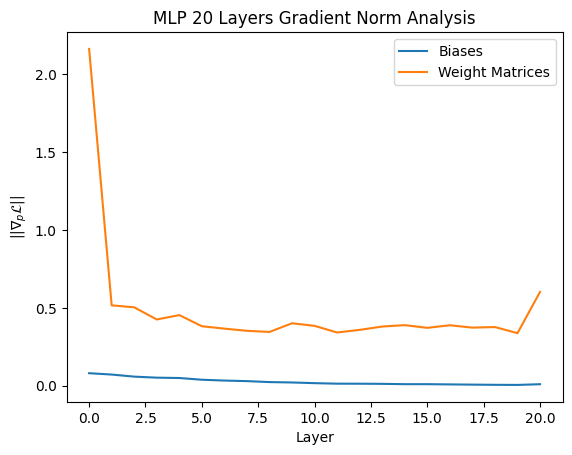

batch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██████
batch_accuracy,▁▁▇█████████████████████████████████████
batch_loss,█▇▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_time,▂▃▁▅▄▂▂▂▂▄▂▃▂▂▁▃▂█▂▁▂▅▄▂▇▁▂▂▃▃▃▆▁▂▁▅▂▇▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▇▇████████████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇▇▇█████████████
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,4284



=== Training MLP with 30 hidden layers ===


[Epoch 1, Batch 25] loss: 4.249 acc: 9.19 time: 0.63
[Epoch 1, Batch 50] loss: 2.364 acc: 9.08 time: 0.43
[Epoch 1, Batch 75] loss: 2.258 acc: 15.44 time: 0.37
[Epoch 1, Batch 100] loss: 2.187 acc: 19.95 time: 0.37
[Epoch 1, Batch 125] loss: 2.093 acc: 26.38 time: 0.39
[Epoch 1, Batch 150] loss: 1.972 acc: 33.88 time: 0.40
[Epoch 1, Batch 175] loss: 1.788 acc: 42.02 time: 0.43
[Epoch 1, Batch 200] loss: 1.563 acc: 47.70 time: 0.41
Epoch 1/20 | Train Loss: 2.2451 | Train Acc: 27.27% | Val Loss: 1.3054 | Val Acc: 55.60%
[Epoch 2, Batch 25] loss: 1.196 acc: 58.75 time: 0.52
[Epoch 2, Batch 50] loss: 1.053 acc: 63.98 time: 0.38
[Epoch 2, Batch 75] loss: 0.911 acc: 69.27 time: 0.35
[Epoch 2, Batch 100] loss: 0.870 acc: 71.55 time: 0.37
[Epoch 2, Batch 125] loss: 0.772 acc: 74.80 time: 0.38
[Epoch 2, Batch 150] loss: 0.724 acc: 76.19 time: 0.36
[Epoch 2, Batch 175] loss: 0.655 acc: 78.72 time: 0.47
[Epoch 2, Batch 200] loss: 0.590 acc: 80.97 time: 0.37
Epoch 2/20 | Train Loss: 0.8256 | Train

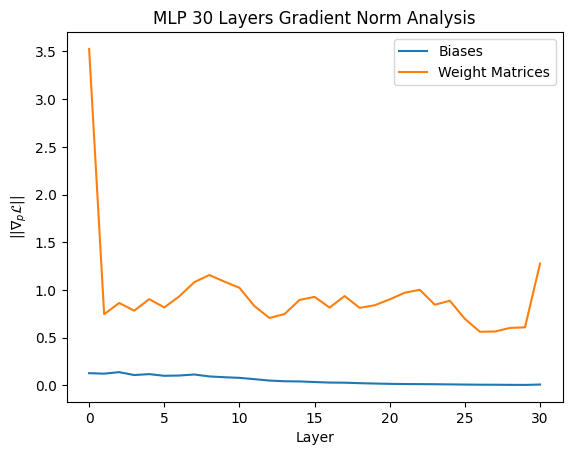

batch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
batch_accuracy,▁▃▇▇▇███████████████████████████████████
batch_loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_time,▂▃▂▂▂▂▂▃▁▂▁▂▂▂▆▁▂▃▁▆█▂▂▂▅▂▂▁▂▂▃▂▁▃▁▃▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▆▇▇▇███████████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇██████████████
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,4284


In [ ]:
hidden_layers_list = [10, 20, 30]
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.0001
early_stopping = False
patience = 5
delta = 0.001
report_list = []

for num_hidden in hidden_layers_list:
    print(f"\n=== Training MLP with {num_hidden} hidden layers ===")
    model = ResidualMLP(input_size, 32, num_hidden, output_size_mnist )
    model = model.to(device)

    opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    run = setup_wandb(project_name="DLA-LAB_1", run_name=f"RESIDUAL_MLP_{num_hidden}_layers")

    # Training
    accuracy_train, loss_train = train_wandb(
        model, criterion, opt, None, epochs, device,
        train_loader, validation_loader,
        early_stopping, patience, delta
    )

    gradient_magnitudes_plot(model, num_hidden)

    run.finish()
    accuracy_test, loss_test, report = evaluate_classification(model, test_loader, criterion, device, return_report=True)
    report_list.append(report)

If we repeat the analysis of gradient magnitudes for the final residual module, we see that there is **much** more gradient signal propagating through the network.

Text(0.5, 1.0, 'Residual Gradient Norm Analysis')

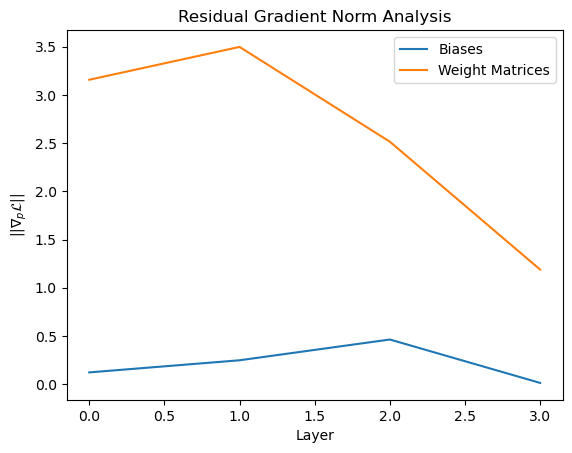

In [ ]:
# Get the tensors corresponding to the gradients of bias parameters.
biases = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 1]

# And get the tensors corresponding to the gradients of weight matrices.
weights = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 2]

# Plot the norms of the biases.
plt.plot([(p * p).sum().sqrt().item() for p in biases])
plt.plot([(p * p).sum().sqrt().item() for p in weights])
plt.xlabel('Layer')
plt.ylabel('$||\\nabla_p \\mathcal{L}||$')
plt.legend(['Biases', 'Weight Matrices'])
plt.title('Residual Gradient Norm Analysis')

## Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving.

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

###DATA PREPARATION (CIFAR-10)

In [ ]:
from torchvision.datasets import CIFAR10

# Standard CIFAR-10 transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 train and test.
ds_train_cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test_cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train_cifar10))
ds_val_cifar10 = Subset(ds_train_cifar10, I[:val_size])
ds_train_cifar10 = Subset(ds_train_cifar10, I[val_size:])

#dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(ds_train_cifar10, batch_size, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(ds_val_cifar10, batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(ds_test_cifar10, batch_size, shuffle=True, num_workers=4)
print("CIFAR-10 Data loaded")

100%|██████████| 170M/170M [00:10<00:00, 15.6MB/s]


CIFAR-10 Data loaded


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
image = next(iter(train_loader))[0][0]
print(image.shape)
input_size_cifar_10 = image.shape[1]
input_channels_cifar_10 = image.shape[0]

torch.Size([3, 32, 32])


###NON RESIDUAL CNN MODEL


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Blocco convolutivo con due conv 3x3 senza skip connection
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class DeepCNN(nn.Module):
    def __init__(self, input_channels, num_classes, depth, base_channels):
        """
        input_channels: canali in input (3 per CIFAR-10)
        num_classes: numero di classi finali
        depth: numero totale di conv layers
        base_channels: numero di canali iniziali
        """
        super().__init__()

        # Primo layer
        self.input_layer = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )

        # Calcola il numero di blocchi convolutivi disponibili
        remaining_conv_layers = depth - 1  # Sottrai il primo conv layer
        total_blocks = remaining_conv_layers // 2

        # Calcola le posizioni di downsampling (in termini di indici di blocco)
        if total_blocks <= 3:
            # Se abbiamo pochi blocchi, usiamo tutti per il downsampling
            downsampling_positions = list(range(min(3, total_blocks)))
        else:
            # Distribuisci i 3 downsampling uniformemente
            step = total_blocks // 4
            downsampling_positions = [step, step * 2, step * 3]

        print(f"Depth: {depth}, Total blocks: {total_blocks}")
        print(f"Downsampling positions: {downsampling_positions}")

        layers = []
        in_channels = base_channels
        channels = base_channels

        for block_idx in range(total_blocks):
            if block_idx in downsampling_positions:
                # Downsampling: stride=2 e raddoppia i canali
                channels *= 2
                layers.append(ConvBlock(in_channels, channels, stride=2))
                print(f"Block {block_idx}: Downsampling - {in_channels} -> {channels} channels")
            else:
                # Nessun downsampling: stride=1, mantieni i canali
                layers.append(ConvBlock(in_channels, channels, stride=1))
                print(f"Block {block_idx}: Regular - {channels} channels")

            in_channels = channels

        self.blocks = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels, num_classes)

        print(f"Final channels: {channels}")

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
def gradient_magnitudes_plot_cnn(model, num_layers):
    """
    Plotta le magnitudini dei gradienti solo per le conv 3×3 principali e per il layer fully-connected finale,
    evitando di includere conv 1×1 delle skip connection.
    """

    main_weights = []
    main_biases = []

    for name, module in model.named_modules():
        # Conv 3×3 principali
        if isinstance(module, torch.nn.Conv2d) and module.kernel_size == (3, 3):
            if module.weight.grad is not None:
                main_weights.append(module.weight.grad.detach().cpu())
            if module.bias is not None and module.bias.grad is not None:
                main_biases.append(module.bias.grad.detach().cpu())

        # Layer fully-connected finale
        if isinstance(module, torch.nn.Linear):
            if module.weight.grad is not None:
                main_weights.append(module.weight.grad.detach().cpu())
            if module.bias is not None and module.bias.grad is not None:
                main_biases.append(module.bias.grad.detach().cpu())

    # Calcolo norme L2
    weight_norms = [(p * p).sum().sqrt().item() for p in main_weights]
    bias_norms   = [(p * p).sum().sqrt().item() for p in main_biases]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(bias_norms, marker='o')
    plt.plot(weight_norms, marker='s')
    plt.xlabel('Layer index (solo conv 3×3 e FC finale)')
    plt.ylabel(r'$||\nabla_p \mathcal{L}||$')
    plt.legend(['Biases', 'Weights'])
    plt.title(f'CNN {num_layers} Layers - Gradient Norm Analysis')
    plt.grid(True)
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.001
early_stopping = True
patience = 5
delta = 0.001
depth = 40
base_channels = 32
block_size = 2

model = DeepCNN(input_channels_cifar_10, 10, depth, base_channels)
model = model.to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',        # perché stiamo monitorando la loss
    factor=0.5,        # dimezza il learning rate
    patience=2,        # aspetta 2 epoche prima di ridurre
    min_lr=1e-6        # limite inferiore
)
criterion = nn.CrossEntropyLoss()

# wandb run initialization
run = setup_wandb(project_name="DLA-LAB_1", run_name="40-DEEP_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
run.finish()

Depth: 40, Total blocks: 19
Downsampling positions: [4, 8, 12]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Regular - 32 channels
Block 3: Regular - 32 channels
Block 4: Downsampling - 32 -> 64 channels
Block 5: Regular - 64 channels
Block 6: Regular - 64 channels
Block 7: Regular - 64 channels
Block 8: Downsampling - 64 -> 128 channels
Block 9: Regular - 128 channels
Block 10: Regular - 128 channels
Block 11: Regular - 128 channels
Block 12: Downsampling - 128 -> 256 channels
Block 13: Regular - 256 channels
Block 14: Regular - 256 channels
Block 15: Regular - 256 channels
Block 16: Regular - 256 channels
Block 17: Regular - 256 channels
Block 18: Regular - 256 channels
Final channels: 256


[Epoch 1, Batch 25] loss: 2.330 acc: 12.38 time: 1.96
[Epoch 1, Batch 50] loss: 2.295 acc: 11.38 time: 1.65
[Epoch 1, Batch 75] loss: 2.281 acc: 12.69 time: 1.43
[Epoch 1, Batch 100] loss: 2.271 acc: 13.19 time: 1.43
[Epoch 1, Batch 125] loss: 2.265 acc: 12.12 time: 1.43
[Epoch 1, Batch 150] loss: 2.279 acc: 13.25 time: 1.44
[Epoch 1, Batch 175] loss: 2.274 acc: 12.44 time: 1.42
[Epoch 1, Batch 200] loss: 2.252 acc: 14.44 time: 1.45
[Epoch 1, Batch 225] loss: 2.197 acc: 16.56 time: 1.45
[Epoch 1, Batch 250] loss: 2.162 acc: 17.38 time: 1.61
[Epoch 1, Batch 275] loss: 2.131 acc: 18.06 time: 1.61
[Epoch 1, Batch 300] loss: 2.105 acc: 17.94 time: 1.44
[Epoch 1, Batch 325] loss: 2.083 acc: 17.94 time: 1.46
[Epoch 1, Batch 350] loss: 2.099 acc: 18.69 time: 1.46
[Epoch 1, Batch 375] loss: 2.109 acc: 18.88 time: 1.45
[Epoch 1, Batch 400] loss: 2.059 acc: 19.25 time: 1.43
[Epoch 1, Batch 425] loss: 2.006 acc: 21.25 time: 1.46
[Epoch 1, Batch 450] loss: 1.989 acc: 22.69 time: 1.45
[Epoch 1, Bat

batch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇███
batch_accuracy,▁▂▂▂▂▂▃▃▃▄▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇███████
batch_loss,█▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
batch_time,▇▆▄▂▂▂▂▂▂█▂▂▂▂▂▂▁▂▂▅▇▂▂▂▂█▁▂▂▂▄▇▃▂▆▇▇▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▂▃▃▄▅▅▆▆▆▇▇▇▇█████
train_loss,█▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁▂▂▃▄▅▅▅▇▇▇▇▇██████
val_loss,██▇▇▇▅▅▄▄▂▃▂▂▂▁▁▁▁▁▁
batch,14075


In [ ]:
run.finish()

### RESIDUAL CNN MODEL

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Blocco residuo con due conv 3x3 e skip connection
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Se cambia la dimensione spaziale o il numero di canali, adattiamo lo skip
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class DeepResidualCNN(nn.Module):
    def __init__(self, input_channels, num_classes, depth, base_channels):
        """
        input_channels: canali in input (3 per CIFAR-10)
        num_classes: numero di classi finali
        depth: numero totale di conv layers
        base_channels: numero di canali iniziali
        """
        super().__init__()

        # Primo layer
        self.input_layer = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )

        # Calcola il numero di blocchi residui disponibili
        remaining_conv_layers = depth - 1  # Sottrai il primo conv layer
        total_blocks = remaining_conv_layers // 2

        # Calcola le posizioni di downsampling (in termini di indici di blocco)
        if total_blocks <= 3:
            # Se abbiamo pochi blocchi, usiamo tutti per il downsampling
            downsampling_positions = list(range(min(3, total_blocks)))
        else:
            # Distribuisci i 3 downsampling uniformemente
            step = total_blocks // 4
            downsampling_positions = [step, step * 2, step * 3]

        print(f"Depth: {depth}, Total blocks: {total_blocks}")
        print(f"Downsampling positions: {downsampling_positions}")

        layers = []
        in_channels = base_channels
        channels = base_channels

        for block_idx in range(total_blocks):
            if block_idx in downsampling_positions:
                # Downsampling: stride=2 e raddoppia i canali
                channels *= 2
                layers.append(ResidualBlock(in_channels, channels, stride=2))
                print(f"Block {block_idx}: Downsampling - {in_channels} -> {channels} channels")
            else:
                # Nessun downsampling: stride=1, mantieni i canali
                layers.append(ResidualBlock(in_channels, channels, stride=1))
                print(f"Block {block_idx}: Regular - {channels} channels")

            in_channels = channels

        self.blocks = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels, num_classes)

        print(f"Final channels: {channels}")

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.001
early_stopping = True
patience = 5
delta = 0.001
depth = 50
base_channels = 32
block_size = 2

# model = DeepResidualCNN(input_channels_cifar_10, 10, depth, base_channels, block_size)
model = DeepResidualCNN(input_channels_cifar_10, 10, depth, base_channels)
model = model.to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',        # perché stiamo monitorando la loss
    factor=0.5,        # dimezza il learning rate
    patience=2,        # aspetta 2 epoche prima di ridurre
    min_lr=1e-6        # limite inferiore
)
criterion = nn.CrossEntropyLoss()

# wandb run initialization
run = setup_wandb(project_name="DLA-LAB_1", run_name="50-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
run.finish()

Depth: 50, Total blocks: 24
Downsampling positions: [6, 12, 18]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Regular - 32 channels
Block 3: Regular - 32 channels
Block 4: Regular - 32 channels
Block 5: Regular - 32 channels
Block 6: Downsampling - 32 -> 64 channels
Block 7: Regular - 64 channels
Block 8: Regular - 64 channels
Block 9: Regular - 64 channels
Block 10: Regular - 64 channels
Block 11: Regular - 64 channels
Block 12: Downsampling - 64 -> 128 channels
Block 13: Regular - 128 channels
Block 14: Regular - 128 channels
Block 15: Regular - 128 channels
Block 16: Regular - 128 channels
Block 17: Regular - 128 channels
Block 18: Downsampling - 128 -> 256 channels
Block 19: Regular - 256 channels
Block 20: Regular - 256 channels
Block 21: Regular - 256 channels
Block 22: Regular - 256 channels
Block 23: Regular - 256 channels
Final channels: 256


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1, Batch 25] loss: 2.259 acc: 20.62 time: 2.19
[Epoch 1, Batch 50] loss: 1.950 acc: 27.06 time: 1.93
[Epoch 1, Batch 75] loss: 1.835 acc: 31.94 time: 1.99
[Epoch 1, Batch 100] loss: 1.829 acc: 33.06 time: 2.17
[Epoch 1, Batch 125] loss: 1.751 acc: 36.19 time: 2.07
[Epoch 1, Batch 150] loss: 1.722 acc: 35.69 time: 1.95
[Epoch 1, Batch 175] loss: 1.624 acc: 37.94 time: 1.95
[Epoch 1, Batch 200] loss: 1.633 acc: 38.44 time: 1.97
[Epoch 1, Batch 225] loss: 1.590 acc: 39.25 time: 1.98
[Epoch 1, Batch 250] loss: 1.524 acc: 41.94 time: 2.04
[Epoch 1, Batch 275] loss: 1.537 acc: 43.69 time: 2.19
[Epoch 1, Batch 300] loss: 1.449 acc: 46.62 time: 1.97
[Epoch 1, Batch 325] loss: 1.472 acc: 44.62 time: 1.94
[Epoch 1, Batch 350] loss: 1.453 acc: 46.69 time: 1.95
[Epoch 1, Batch 375] loss: 1.468 acc: 45.44 time: 1.96
[Epoch 1, Batch 400] loss: 1.397 acc: 48.12 time: 1.94
[Epoch 1, Batch 425] loss: 1.443 acc: 45.81 time: 2.13
[Epoch 1, Batch 450] loss: 1.281 acc: 53.62 time: 2.10
[Epoch 1, Bat

batch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
batch_accuracy,▁▂▂▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
batch_loss,█▇▇▇▆▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
batch_time,▇▄▂▂▂▁▂▁▁▇▅▆▂▇▂▂▂▁▁▁▆▂▂▄▅▁▁█▃▃▃▁█▆▃▁▁▇▂▂
epoch,▁▂▂▃▄▄▅▅▆▇▇█
learning_rate,██████████▁▁
train_accuracy,▁▄▅▅▆▆▇▇▇▇██
train_loss,█▆▄▄▃▃▂▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇█▇███
val_loss,█▄▃▂▂▁▁▁▂▂▃▄
batch,8443


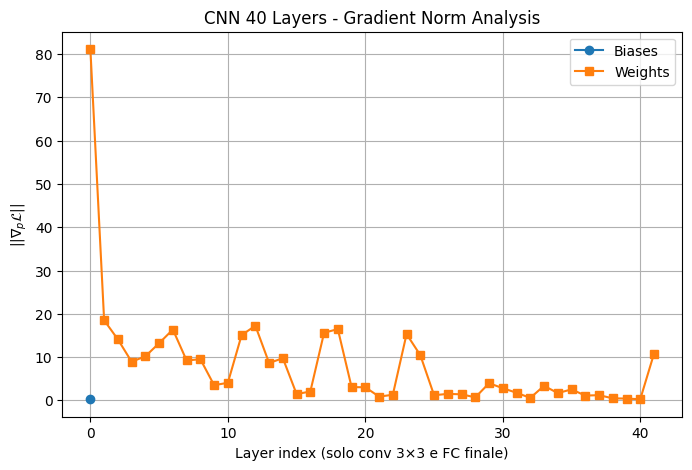

In [ ]:
gradient_magnitudes_plot_cnn(model, depth)

after 30 layers, residual outperform non residual cnn, manteining the net stable.

However, we see symptoms of overfitting affecting our network, probably due to a less aggressive data augmentation.


### IMPROVING NET PERFORMANCES

let's try to improve again our net prestation. I will use a 20 layer deep residual cnn

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 train and test.
ds_train_cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test_cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train_cifar10))
ds_val_cifar10 = Subset(ds_train_cifar10, I[:val_size])
ds_train_cifar10 = Subset(ds_train_cifar10, I[val_size:])

#dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(ds_train_cifar10, batch_size, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(ds_val_cifar10, batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(ds_test_cifar10, batch_size, shuffle=True, num_workers=4)
print("CIFAR-10 Data loaded")

CIFAR-10 Data loaded


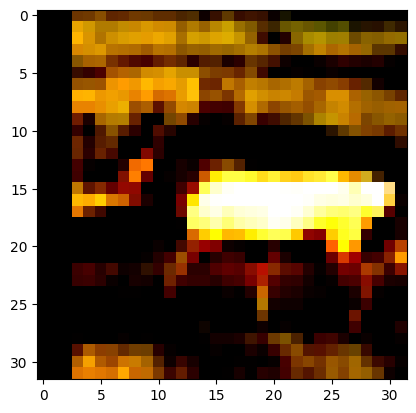

In [ ]:
image = next(iter(train_loader))[0][0]
plt.imshow(image.permute(1, 2, 0))

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.001
early_stopping = True
patience = 5
delta = 0.001
depth = 20
base_channels = 32
block_size = 2

model = DeepResidualCNN(input_channels_cifar_10, 10, depth, base_channels)
model = model.to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',        # perché stiamo monitorando la loss
    factor=0.5,        # dimezza il learning rate
    patience=2,        # aspetta 2 epoche prima di ridurre
    min_lr=1e-6        # limite inferiore
)
criterion = nn.CrossEntropyLoss()

# wandb run initialization
run = setup_wandb(project_name="DLA-LAB_1", run_name="IMPROVED_20-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
torch.save(model.state_dict(), 'improved_18_deep_residual_cnn.pth') # Save locally first
model_path = save_model_to_wandb(model, "improved_18_deep_residual_cnn.pth", run) # Log to wandb before finishing the run
run.finish()

Depth: 20, Total blocks: 9
Downsampling positions: [2, 4, 6]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Downsampling - 32 -> 64 channels
Block 3: Regular - 64 channels
Block 4: Downsampling - 64 -> 128 channels
Block 5: Regular - 128 channels
Block 6: Downsampling - 128 -> 256 channels
Block 7: Regular - 256 channels
Block 8: Regular - 256 channels
Final channels: 256


[Epoch 1, Batch 25] loss: 2.197 acc: 19.56 time: 1.20
[Epoch 1, Batch 50] loss: 1.955 acc: 27.94 time: 0.88
[Epoch 1, Batch 75] loss: 1.827 acc: 28.94 time: 0.89
[Epoch 1, Batch 100] loss: 1.719 acc: 36.69 time: 0.87
[Epoch 1, Batch 125] loss: 1.744 acc: 35.56 time: 1.05
[Epoch 1, Batch 150] loss: 1.659 acc: 38.62 time: 1.24
[Epoch 1, Batch 175] loss: 1.623 acc: 39.50 time: 1.19
[Epoch 1, Batch 200] loss: 1.597 acc: 39.12 time: 1.08
[Epoch 1, Batch 225] loss: 1.501 acc: 45.38 time: 0.86
[Epoch 1, Batch 250] loss: 1.542 acc: 43.38 time: 0.87
[Epoch 1, Batch 275] loss: 1.531 acc: 44.88 time: 0.86
[Epoch 1, Batch 300] loss: 1.473 acc: 46.94 time: 0.84
[Epoch 1, Batch 325] loss: 1.427 acc: 48.19 time: 0.86
[Epoch 1, Batch 350] loss: 1.457 acc: 44.75 time: 0.87
[Epoch 1, Batch 375] loss: 1.390 acc: 48.75 time: 0.86
[Epoch 1, Batch 400] loss: 1.362 acc: 51.81 time: 0.86
[Epoch 1, Batch 425] loss: 1.299 acc: 54.38 time: 0.90
[Epoch 1, Batch 450] loss: 1.351 acc: 52.62 time: 0.96
[Epoch 1, Bat

batch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
batch_accuracy,▁▅▅▅▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇███████
batch_loss,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
batch_time,▆▇▂▁▁▁▃▁▂▂▇▁▂▁▇▇▁▆▅▁▆▆▂█▇▇▂▁▅▂▂▂▂▂▂▂▂▇▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,██████████████████▁▁
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇██▇███
val_loss,█▆▅▄▃▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁
batch,14075


The model is saved in wandb so I can you use it for the other exercises


### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

#### Start:Preparing Cifar-100

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
# Trasformazioni standard per CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Caricamento train e test
ds_train_cifar100 = CIFAR100(root='./data', train=True, download=True, transform=transform)
ds_test_cifar100  = CIFAR100(root='./data', train=False, download=True, transform=transform)

# Split train in train e validation
val_size = 5000
I = np.random.permutation(len(ds_train_cifar100))
ds_val_cifar100   = Subset(ds_train_cifar100, I[:val_size])
ds_train_cifar100 = Subset(ds_train_cifar100, I[val_size:])

# DataLoaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(ds_train_cifar100, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(ds_val_cifar100, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(ds_test_cifar100, batch_size=batch_size, shuffle=False, num_workers=4)

print("CIFAR-100 Data loaded")


100%|██████████| 169M/169M [00:06<00:00, 26.5MB/s]


CIFAR-100 Data loaded


####Phase 0: feature extractor and baseline

In [ ]:
def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            imgs = imgs.to(device)

            # Forward pass fino al global pooling (prima del classificatore)
            x = model.input_layer(imgs)      # attraversa input_layer
            x = model.blocks(x)              # attraversa tutti i blocks
            x = model.global_pool(x)         # adaptive avg pooling
            features = torch.flatten(x, 1)  # flatten per ottenere vettore 1D

            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

            # Progress indicator
            if batch_idx % 50 == 0:
                print(f'Extracting features: batch {batch_idx}/{len(dataloader)}')

    # Concatena tutti i batch
    X = np.concatenate(features_list, axis=0)
    y = np.concatenate(labels_list, axis=0)

    print(f"Features estratte: X.shape = {X.shape}, y.shape = {y.shape}")
    return X, y

In [ ]:
base_channels = 32
input_channels_cifar_10 = 3
depth = 20

In [ ]:
print("Scaricamento del modello preaddestrato da wandb...")
try:
    run = wandb.init()
    artifact = run.use_artifact('mencucci-marco-universit-di-firenze/DLA-LAB_1/improved_20_deep_residual_cnn.pth:v1', type='model')
    model_dir = artifact.download()
    print("Artifact scaricato in:", model_dir)
    model_path = f"{model_dir}/improved_18_deep_residual_cnn.pth"
    print("qui")
    model = DeepResidualCNN(input_channels_cifar_10, 10, depth, base_channels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Modello caricato con successo!")

except Exception as e:
    print(f"Errore nel caricamento del modello: {e}")

model = model.to(device)

Scaricamento del modello preaddestrato da wandb...


wandb:   1 of 1 files downloaded.  


Artifact scaricato in: /content/artifacts/improved_20_deep_residual_cnn.pth:v1
qui
Depth: 20, Total blocks: 9
Downsampling positions: [2, 4, 6]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Downsampling - 32 -> 64 channels
Block 3: Regular - 64 channels
Block 4: Downsampling - 64 -> 128 channels
Block 5: Regular - 128 channels
Block 6: Downsampling - 128 -> 256 channels
Block 7: Regular - 256 channels
Block 8: Regular - 256 channels
Final channels: 256
Modello caricato con successo!


In [ ]:
model

DeepResidualCNN(
  (input_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
X_train, y_train = extract_features(model, train_loader, device)
X_test, y_test   = extract_features(model, test_loader, device)

Extracting features: batch 0/704
Extracting features: batch 50/704
Extracting features: batch 100/704
Extracting features: batch 150/704
Extracting features: batch 200/704
Extracting features: batch 250/704
Extracting features: batch 300/704
Extracting features: batch 350/704
Extracting features: batch 400/704
Extracting features: batch 450/704
Extracting features: batch 500/704
Extracting features: batch 550/704
Extracting features: batch 600/704
Extracting features: batch 650/704
Extracting features: batch 700/704
Features estratte: X.shape = (45000, 256), y.shape = (45000,)
Extracting features: batch 0/157
Extracting features: batch 50/157
Extracting features: batch 100/157
Extracting features: batch 150/157
Features estratte: X.shape = (10000, 256), y.shape = (10000,)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
clf = LinearSVC(max_iter=5000)
clf.fit(X_train_scaled, y_train)

LinearSVC(max_iter=5000)

In [ ]:
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"CIFAR-100 Linear SVM Accuracy using features: {acc*100:.2f}%")

CIFAR-100 Linear SVM Accuracy using features: 41.97%


####Phase 1: adapting the model and train the classification head

In [ ]:
num_features = model.fc.in_features
print(num_features)
model.fc = nn.Linear(num_features, 100).to(device)

256


In [ ]:
model

DeepResidualCNN(
  (input_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
param_to_train = 0
param_total = 0

for name, param in model.named_parameters():
    param_total += param.numel()
    if 'fc' not in name:
        param.requires_grad = False
    else:
        param_to_train += param.numel()
        print(f"Parametri attivi: {name}")

print(f"Training only {param_to_train} parameters over {param_total} total ({100*param_to_train/param_total:.2f}%)")


Parametri attivi: fc.weight
Parametri attivi: fc.bias
Training only 25700 parameters over 4001412 total (0.64%)


In [ ]:
devices = {p.device for p in model.parameters()}
print(f"Devices usati nel modello: {devices}")

Devices usati nel modello: {device(type='cuda', index=0)}


In [ ]:
epochs = 20
lr = 0.01
early_stopping = True
patience = 5
delta = 0.001

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
# opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
criterion = nn.CrossEntropyLoss()

run = setup_wandb(project_name="DLA-LAB_1", run_name="ADAM_LP_20-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
torch.save(model.state_dict(), 'LP_20_deep_residual_cnn.pth')
model_path = save_model_to_wandb(model, "LP_20_deep_residual_cnn.pth", run)
run.finish()

[Epoch 1, Batch 25] loss: 4.770 acc: 5.38 time: 0.64
[Epoch 1, Batch 50] loss: 3.906 acc: 11.75 time: 0.41
[Epoch 1, Batch 75] loss: 3.745 acc: 15.31 time: 0.59
[Epoch 1, Batch 100] loss: 3.623 acc: 17.56 time: 0.42
[Epoch 1, Batch 125] loss: 3.647 acc: 16.06 time: 0.42
[Epoch 1, Batch 150] loss: 3.568 acc: 18.25 time: 0.45
[Epoch 1, Batch 175] loss: 3.450 acc: 18.19 time: 0.42
[Epoch 1, Batch 200] loss: 3.469 acc: 20.12 time: 0.44
[Epoch 1, Batch 225] loss: 3.466 acc: 17.62 time: 0.41
[Epoch 1, Batch 250] loss: 3.459 acc: 18.69 time: 0.43
[Epoch 1, Batch 275] loss: 3.434 acc: 20.50 time: 0.41
[Epoch 1, Batch 300] loss: 3.367 acc: 22.88 time: 0.41
[Epoch 1, Batch 325] loss: 3.245 acc: 22.75 time: 0.44
[Epoch 1, Batch 350] loss: 3.251 acc: 22.12 time: 0.40
[Epoch 1, Batch 375] loss: 3.391 acc: 22.38 time: 0.43
[Epoch 1, Batch 400] loss: 3.385 acc: 21.25 time: 0.43
[Epoch 1, Batch 425] loss: 3.347 acc: 22.00 time: 0.42
[Epoch 1, Batch 450] loss: 3.278 acc: 23.75 time: 0.44
[Epoch 1, Batc

batch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇██
batch_accuracy,▁▂▂▂▃▃▄▄▄▄▄▄▅▄▅▄▅▅▆▆▆▆▆▇▆▆▆▇▇█▇▇███████▇
batch_loss,█▇▇▆▅▅▅▄▄▄▄▄▄▅▄▄▄▄▄▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▂▁▁▁▁
batch_time,▁▂▁▇▄▇▆▁█▂▁▆▇▁▂▂▂▂▁▂▂▂▂▂▂▂█▂▁▂█▇▇█▂▄▂▂█▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,████████▃▃▃▃▃▃▃▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▅▇▇▇▇▇▇▇█████
train_loss,█▆▅▅▅▅▄▄▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▄▄▅▄▃▄▆▇▆▇▇▆▆▇████
val_loss,█▆▅▆▅▆▆▆▃▃▃▃▃▃▃▁▁▁▁▁
batch,14075


lets proceed with the ft


####Phase 2:continuing to unlock the model (fc + block.8)

In [ ]:
print("Scaricamento del modello LP da wandb...")
try:
    run = wandb.init()
    artifact = run.use_artifact('mencucci-marco-universit-di-firenze/DLA-LAB_1/LP_20_deep_residual_cnn.pth:v5', type='model')
    model_dir = artifact.download()
    model_path = f"{model_dir}/LP_20_deep_residual_cnn.pth"

    model = DeepResidualCNN(3, 100, 20, 32)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Modello caricato con successo!")

except Exception as e:
    print(f"Errore nel caricamento del modello: {e}")

model = model.to(device)

Scaricamento del modello LP da wandb...


wandb:   1 of 1 files downloaded.  


Depth: 20, Total blocks: 9
Downsampling positions: [2, 4, 6]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Downsampling - 32 -> 64 channels
Block 3: Regular - 64 channels
Block 4: Downsampling - 64 -> 128 channels
Block 5: Regular - 128 channels
Block 6: Downsampling - 128 -> 256 channels
Block 7: Regular - 256 channels
Block 8: Regular - 256 channels
Final channels: 256
Modello caricato con successo!


In [ ]:
model

DeepResidualCNN(
  (input_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
param_to_train = 0
param_total = 0

for name, param in model.named_parameters():
    param_total += param.numel()
    if 'fc' in name or 'blocks.8' in name:
        param.requires_grad = True
        param_to_train += param.numel()
        print(f"Parametri attivi: {name}")
    else:
        param.requires_grad = False

print(f"Training solo {param_to_train} parametri su {param_total} totali "
      f"({100*param_to_train/param_total:.2f}%)")


Parametri attivi: blocks.8.conv1.weight
Parametri attivi: blocks.8.bn1.weight
Parametri attivi: blocks.8.bn1.bias
Parametri attivi: blocks.8.conv2.weight
Parametri attivi: blocks.8.bn2.weight
Parametri attivi: blocks.8.bn2.bias
Parametri attivi: fc.weight
Parametri attivi: fc.bias
Training solo 1206372 parametri su 4001412 totali (30.15%)


In [ ]:
devices = {p.device for p in model.parameters()}
print(f"Devices usati nel modello: {devices}")

Devices usati nel modello: {device(type='cuda', index=0)}


In [ ]:
epochs = 20
lr_adam = 1e-4
lr_sgd = 0.01
early_stopping = True
patience = 6
delta = 0.001

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd, momentum=0.9)
# opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
criterion = nn.CrossEntropyLoss()

run = setup_wandb(project_name="DLA-LAB_1", run_name="adam_FT0_20-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
torch.save(model.state_dict(), 'FT0_20_deep_residual_cnn.pth')
model_path = save_model_to_wandb(model, "FT0_20_deep_residual_cnn.pth", run)
run.finish()

[Epoch 1, Batch 25] loss: 2.177 acc: 43.81 time: 0.67
[Epoch 1, Batch 50] loss: 2.041 acc: 45.69 time: 0.43
[Epoch 1, Batch 75] loss: 2.087 acc: 45.06 time: 0.59
[Epoch 1, Batch 100] loss: 2.086 acc: 45.12 time: 0.48
[Epoch 1, Batch 125] loss: 2.068 acc: 46.44 time: 0.47
[Epoch 1, Batch 150] loss: 1.980 acc: 48.25 time: 0.45
[Epoch 1, Batch 175] loss: 2.089 acc: 45.94 time: 0.44
[Epoch 1, Batch 200] loss: 2.059 acc: 45.62 time: 0.43
[Epoch 1, Batch 225] loss: 2.023 acc: 46.06 time: 0.44
[Epoch 1, Batch 250] loss: 2.091 acc: 46.56 time: 0.58
[Epoch 1, Batch 275] loss: 2.081 acc: 45.81 time: 0.64
[Epoch 1, Batch 300] loss: 2.055 acc: 45.50 time: 0.70
[Epoch 1, Batch 325] loss: 2.049 acc: 46.62 time: 0.69
[Epoch 1, Batch 350] loss: 2.060 acc: 47.12 time: 0.67
[Epoch 1, Batch 375] loss: 1.955 acc: 48.69 time: 0.67
[Epoch 1, Batch 400] loss: 2.075 acc: 45.12 time: 0.44
[Epoch 1, Batch 425] loss: 2.069 acc: 45.69 time: 0.45
[Epoch 1, Batch 450] loss: 2.093 acc: 44.44 time: 0.44
[Epoch 1, Bat

batch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
batch_accuracy,▁▂▁▂▄▃▃▅▃▃▂▄▄▄▅▂▂▅▂▂▂▃▁▄▇▂▅▇▅▄▅▄▅▇▆▅▅▆▆█
batch_loss,█▇▅▅▄▇▄██▃▃▆▅▇▅▄▇█▅▅▅▆▅▃▅▇▂▅▄▅▄▅▂▃▅▄▂▁▂▂
batch_time,▅▂▁▂▁▁▂█▂▂▁▂▅▁▁▂▄▁▂▂▂▁▁▆▁▂▁▅▁▁▂▂▂▂▁▁▅▅▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,███████████▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▃▃▄▄▃▄▄▅▅▆▆▇▇▇▇▇█
train_loss,█▇▆▆▆▆▅▅▅▅▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▁▂▃▃▃▃▄▄▄▅▅▆▇▆▅▇▆██
val_loss,█▇▆▆▇▆▄▄▅▅▄▅▃▃▄▅▃▂▁▃
batch,14075


####Phase 3: continuing to unlock the model (fc+blocks.8+blocks.7)

In [ ]:
print("Scaricamento del modello FT da wandb...")
try:
    run = wandb.init()
    artifact = run.use_artifact('mencucci-marco-universit-di-firenze/DLA-LAB_1/FT0_20_deep_residual_cnn.pth:v1', type='model')
    model_dir = artifact.download()
    model_path = f"{model_dir}/FT0_20_deep_residual_cnn.pth"

    model = DeepResidualCNN(3, 100, 20, 32)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Modello caricato con successo!")

except Exception as e:
    print(f"Errore nel caricamento del modello: {e}")

model = model.to(device)

Scaricamento del modello FT da wandb...


wandb:   1 of 1 files downloaded.  


Depth: 20, Total blocks: 9
Downsampling positions: [2, 4, 6]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Downsampling - 32 -> 64 channels
Block 3: Regular - 64 channels
Block 4: Downsampling - 64 -> 128 channels
Block 5: Regular - 128 channels
Block 6: Downsampling - 128 -> 256 channels
Block 7: Regular - 256 channels
Block 8: Regular - 256 channels
Final channels: 256
Modello caricato con successo!


In [ ]:
param_to_train = 0
param_total = 0

for name, param in model.named_parameters():
    param_total += param.numel()
    if ('fc' in name) or ('blocks.8' in name) or ('blocks.7' in name):
        param.requires_grad = True
        param_to_train += param.numel()
        print(f"Parametri attivi: {name}")
    else:
        param.requires_grad = False

print(f"Training solo {param_to_train} parametri su {param_total} totali "
      f"({100*param_to_train/param_total:.2f}%)")


Parametri attivi: blocks.7.conv1.weight
Parametri attivi: blocks.7.bn1.weight
Parametri attivi: blocks.7.bn1.bias
Parametri attivi: blocks.7.conv2.weight
Parametri attivi: blocks.7.bn2.weight
Parametri attivi: blocks.7.bn2.bias
Parametri attivi: blocks.8.conv1.weight
Parametri attivi: blocks.8.bn1.weight
Parametri attivi: blocks.8.bn1.bias
Parametri attivi: blocks.8.conv2.weight
Parametri attivi: blocks.8.bn2.weight
Parametri attivi: blocks.8.bn2.bias
Parametri attivi: fc.weight
Parametri attivi: fc.bias
Training solo 2387044 parametri su 4001412 totali (59.66%)


In [ ]:
epochs = 20
lr_adam = 1e-4
lr_sgd = 0.01
early_stopping = True
patience = 6
delta = 0.001

# opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd, momentum=0.9)
# opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
criterion = nn.CrossEntropyLoss()

run = setup_wandb(project_name="DLA-LAB_1", run_name="sgd_FT1_20-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
torch.save(model.state_dict(), 'FT1_20_deep_residual_cnn.pth')
model_path = save_model_to_wandb(model, "FT1_20_deep_residual_cnn.pth", run)
run.finish()

[Epoch 1, Batch 25] loss: 1.849 acc: 50.88 time: 0.69
[Epoch 1, Batch 50] loss: 1.799 acc: 49.38 time: 0.44
[Epoch 1, Batch 75] loss: 1.776 acc: 51.38 time: 0.46
[Epoch 1, Batch 100] loss: 1.852 acc: 51.12 time: 0.44
[Epoch 1, Batch 125] loss: 1.837 acc: 51.25 time: 0.44
[Epoch 1, Batch 150] loss: 1.944 acc: 49.38 time: 0.46
[Epoch 1, Batch 175] loss: 1.810 acc: 50.56 time: 0.43
[Epoch 1, Batch 200] loss: 1.844 acc: 49.38 time: 0.46
[Epoch 1, Batch 225] loss: 1.810 acc: 51.19 time: 0.44
[Epoch 1, Batch 250] loss: 1.877 acc: 49.38 time: 0.44
[Epoch 1, Batch 275] loss: 1.776 acc: 52.62 time: 0.45
[Epoch 1, Batch 300] loss: 1.878 acc: 49.19 time: 0.44
[Epoch 1, Batch 325] loss: 1.766 acc: 53.38 time: 0.46
[Epoch 1, Batch 350] loss: 1.906 acc: 49.81 time: 0.44
[Epoch 1, Batch 375] loss: 1.913 acc: 48.69 time: 0.73
[Epoch 1, Batch 400] loss: 1.846 acc: 50.69 time: 0.71
[Epoch 1, Batch 425] loss: 1.827 acc: 51.44 time: 0.66
[Epoch 1, Batch 450] loss: 1.865 acc: 51.50 time: 0.73
[Epoch 1, Bat

batch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇████
batch_accuracy,▄▁▁▅▆▃▆█▄▆▆▄▄▃▃▄▅▆▄▄▃▅▆▅▃▅▇▄▅▅▅▃▅▃▆▇▇▄▄▆
batch_loss,▅▇▂█▆▅▄▆▃▆▅▅▅▄▄▆▄▂▄▃▁▄▇▃▅▂▇▃▃▃▄▅▅▂▃▄▂▁▆▁
batch_time,▁▁▃▃▂▁▁▁▁▁▁▁▁▂▁▁▂▃█▁▃▁▁▁▁▁▁▁▃▁▁▂▂▁▃▁▁▁▁▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
learning_rate,██████████▁▁▁
train_accuracy,▁▂▂▁▂▃▅▅▆▅█▇▆
train_loss,█▆▆▆▆▅▄▃▃▂▁▁▁
val_accuracy,▂▁▄▂▁▄▆▅▄▂▇█▃
val_loss,█▇▆▅▃▇▁▂▃▄▄▁▃
batch,9147


In [ ]:
run.finish()

####Phase 4: continuing to unlock the model (fc+blocks.8+blocks.7+blocks.6)

In [ ]:
print("Scaricamento del modello FT da wandb...")
try:
    run = wandb.init()
    # artifact = run.use_artifact('mencucci-marco-universit-di-firenze/vit-self-supervised-rotation/ROT_ViT_1.pth:v0', type='model')
    artifact = run.use_artifact('mencucci-marco-universit-di-firenze/DLA-LAB_1/FT1_20_deep_residual_cnn.pth:v1', type='model')
    model_dir = artifact.download()
    model_path = f"{model_dir}/FT1_20_deep_residual_cnn.pth"

    model = DeepResidualCNN(3, 100, 20, 32)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Modello caricato con successo!")

except Exception as e:
    print(f"Errore nel caricamento del modello: {e}")

model = model.to(device)

Scaricamento del modello FT da wandb...


wandb:   1 of 1 files downloaded.  


Depth: 20, Total blocks: 9
Downsampling positions: [2, 4, 6]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Downsampling - 32 -> 64 channels
Block 3: Regular - 64 channels
Block 4: Downsampling - 64 -> 128 channels
Block 5: Regular - 128 channels
Block 6: Downsampling - 128 -> 256 channels
Block 7: Regular - 256 channels
Block 8: Regular - 256 channels
Final channels: 256
Modello caricato con successo!


In [ ]:
param_to_train = 0
param_total = 0

for name, param in model.named_parameters():
    param_total += param.numel()
    if ('fc' in name) or ('blocks.8' in name) or ('blocks.7' in name) or ('blocks.6' in name):
        param.requires_grad = True
        param_to_train += param.numel()
        print(f"Parametri attivi: {name}")
    else:
        param.requires_grad = False

print(f"Training solo {param_to_train} parametri su {param_total} totali "
      f"({100*param_to_train/param_total:.2f}%)")


Parametri attivi: blocks.6.conv1.weight
Parametri attivi: blocks.6.bn1.weight
Parametri attivi: blocks.6.bn1.bias
Parametri attivi: blocks.6.conv2.weight
Parametri attivi: blocks.6.bn2.weight
Parametri attivi: blocks.6.bn2.bias
Parametri attivi: blocks.6.skip.0.weight
Parametri attivi: blocks.6.skip.1.weight
Parametri attivi: blocks.6.skip.1.bias
Parametri attivi: blocks.7.conv1.weight
Parametri attivi: blocks.7.bn1.weight
Parametri attivi: blocks.7.bn1.bias
Parametri attivi: blocks.7.conv2.weight
Parametri attivi: blocks.7.bn2.weight
Parametri attivi: blocks.7.bn2.bias
Parametri attivi: blocks.8.conv1.weight
Parametri attivi: blocks.8.bn1.weight
Parametri attivi: blocks.8.bn1.bias
Parametri attivi: blocks.8.conv2.weight
Parametri attivi: blocks.8.bn2.weight
Parametri attivi: blocks.8.bn2.bias
Parametri attivi: fc.weight
Parametri attivi: fc.bias
Training solo 3306084 parametri su 4001412 totali (82.62%)


In [ ]:
epochs = 20
lr_adam = 1e-4
lr_sgd = 0.01
early_stopping = True
patience = 6
delta = 0.001

# opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd, momentum=0.9)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
criterion = nn.CrossEntropyLoss()

run = setup_wandb(project_name="DLA-LAB_1", run_name="adamW_FT2_20-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
torch.save(model.state_dict(), 'FT2_20_deep_residual_cnn.pth')
model_path = save_model_to_wandb(model, "FT2_20_deep_residual_cnn.pth", run)
run.finish()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1, Batch 25] loss: 1.244 acc: 65.81 time: 0.72
[Epoch 1, Batch 50] loss: 1.227 acc: 66.06 time: 0.49
[Epoch 1, Batch 75] loss: 1.180 acc: 68.62 time: 0.46
[Epoch 1, Batch 100] loss: 1.300 acc: 64.56 time: 0.49
[Epoch 1, Batch 125] loss: 1.257 acc: 65.12 time: 0.46
[Epoch 1, Batch 150] loss: 1.243 acc: 65.25 time: 0.48
[Epoch 1, Batch 175] loss: 1.284 acc: 64.38 time: 0.47
[Epoch 1, Batch 200] loss: 1.231 acc: 66.56 time: 0.48
[Epoch 1, Batch 225] loss: 1.337 acc: 63.75 time: 0.54
[Epoch 1, Batch 250] loss: 1.326 acc: 62.50 time: 0.49
[Epoch 1, Batch 275] loss: 1.331 acc: 62.94 time: 0.57
[Epoch 1, Batch 300] loss: 1.273 acc: 64.94 time: 0.74
[Epoch 1, Batch 325] loss: 1.196 acc: 68.00 time: 0.75
[Epoch 1, Batch 350] loss: 1.227 acc: 65.06 time: 0.73
[Epoch 1, Batch 375] loss: 1.271 acc: 63.44 time: 0.78
[Epoch 1, Batch 400] loss: 1.277 acc: 64.25 time: 0.76
[Epoch 1, Batch 425] loss: 1.318 acc: 62.81 time: 0.49
[Epoch 1, Batch 450] loss: 1.284 acc: 65.56 time: 0.50
[Epoch 1, Bat

batch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
batch_accuracy,▃▂▁▁▁▂▂▂▃▃▃▂▃▃▃▄▄▄▅▅▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆█▇█▇█
batch_loss,▇▇▇▇█▆▆▇▇▆▆▆▆▅▆▆▅▅▅▅▄▅▄▅▄▃▄▄▄▄▃▃▃▃▂▁▁▁▁▂
batch_time,▁▁▂▁▂▂▂▁▁▂▁▆▇▂▁▆▂▁▂▁▁▄▆▂▂▂▂▂▂▆▁▅▃▁█▂▅▂▁▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
learning_rate,█████████▁▁▁
train_accuracy,▁▂▂▃▄▄▅▆▆▇██
train_loss,█▇▇▆▅▄▄▃▃▂▁▁
val_accuracy,▁▂▄▄▄▇▅█▇▆▆▇
val_loss,▃▃▂▁▃▁▃▄▃▆▆█
batch,8443


We can see again that our model is affected by overfitting => let's try again with some data augmentation

####Phase 5: resolving overfitting

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

ds_train_cifar100 = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
ds_test_cifar100  = CIFAR100(root='./data', train=False, download=True, transform=transform_val_test)

val_size = 5000
I = np.random.permutation(len(ds_train_cifar100))
ds_val_cifar100   = Subset(ds_train_cifar100, I[:val_size])
ds_train_cifar100 = Subset(ds_train_cifar100, I[val_size:])

batch_size = 64
train_loader = torch.utils.data.DataLoader(ds_train_cifar100, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(ds_val_cifar100, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(ds_test_cifar100, batch_size=batch_size, shuffle=False, num_workers=4)

print("CIFAR-100 Data loaded with augmented training set")


100%|██████████| 169M/169M [00:11<00:00, 14.6MB/s]


CIFAR-100 Data loaded with augmented training set


In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
print("Scaricamento del modello FT da wandb...")
try:
    run = wandb.init()
    artifact = run.use_artifact('mencucci-marco-universit-di-firenze/DLA-LAB_1/FT1_20_deep_residual_cnn.pth:v1', type='model')
    model_dir = artifact.download()
    model_path = f"{model_dir}/FT1_20_deep_residual_cnn.pth"

    model = DeepResidualCNN(3, 100, 20, 32)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Modello caricato con successo!")

except Exception as e:
    print(f"Errore nel caricamento del modello: {e}")

model = model.to(device)

Scaricamento del modello FT da wandb...


wandb:   1 of 1 files downloaded.  


Depth: 20, Total blocks: 9
Downsampling positions: [2, 4, 6]
Block 0: Regular - 32 channels
Block 1: Regular - 32 channels
Block 2: Downsampling - 32 -> 64 channels
Block 3: Regular - 64 channels
Block 4: Downsampling - 64 -> 128 channels
Block 5: Regular - 128 channels
Block 6: Downsampling - 128 -> 256 channels
Block 7: Regular - 256 channels
Block 8: Regular - 256 channels
Final channels: 256
Modello caricato con successo!


In [ ]:
param_to_train = 0
param_total = 0

for name, param in model.named_parameters():
    param_total += param.numel()
    if ('fc' in name) or ('blocks.8' in name) or ('blocks.7' in name) or ('blocks.6' in name):
        param.requires_grad = True
        param_to_train += param.numel()
        print(f"Parametri attivi: {name}")
    else:
        param.requires_grad = False

print(f"Training solo {param_to_train} parametri su {param_total} totali "
      f"({100*param_to_train/param_total:.2f}%)")


Parametri attivi: blocks.6.conv1.weight
Parametri attivi: blocks.6.bn1.weight
Parametri attivi: blocks.6.bn1.bias
Parametri attivi: blocks.6.conv2.weight
Parametri attivi: blocks.6.bn2.weight
Parametri attivi: blocks.6.bn2.bias
Parametri attivi: blocks.6.skip.0.weight
Parametri attivi: blocks.6.skip.1.weight
Parametri attivi: blocks.6.skip.1.bias
Parametri attivi: blocks.7.conv1.weight
Parametri attivi: blocks.7.bn1.weight
Parametri attivi: blocks.7.bn1.bias
Parametri attivi: blocks.7.conv2.weight
Parametri attivi: blocks.7.bn2.weight
Parametri attivi: blocks.7.bn2.bias
Parametri attivi: blocks.8.conv1.weight
Parametri attivi: blocks.8.bn1.weight
Parametri attivi: blocks.8.bn1.bias
Parametri attivi: blocks.8.conv2.weight
Parametri attivi: blocks.8.bn2.weight
Parametri attivi: blocks.8.bn2.bias
Parametri attivi: fc.weight
Parametri attivi: fc.bias
Training solo 3306084 parametri su 4001412 totali (82.62%)


In [ ]:
epochs = 20
lr_adam = 1e-4
lr_sgd = 0.01
early_stopping = True
patience = 6
delta = 0.001

# opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd, momentum=0.9)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_adam)
# opt = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_sgd)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
criterion = nn.CrossEntropyLoss()

run = setup_wandb(project_name="DLA-LAB_1", run_name="adamW+dataAUG_FT2_20-DEEP_RESIDUAL_CNN_experiment")
accuracy_train, loss_train = train_wandb(model, criterion, opt, scheduler, epochs, device, train_loader, validation_loader, early_stopping, patience, delta)
torch.save(model.state_dict(), 'FT2_20_deep_residual_cnn.pth')
model_path = save_model_to_wandb(model, "FT2_20_deep_residual_cnn.pth", run)
run.finish()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1, Batch 25] loss: 2.331 acc: 39.88 time: 3.16
[Epoch 1, Batch 50] loss: 2.256 acc: 42.00 time: 1.29
[Epoch 1, Batch 75] loss: 2.271 acc: 39.81 time: 1.17
[Epoch 1, Batch 100] loss: 2.266 acc: 39.69 time: 1.32
[Epoch 1, Batch 125] loss: 2.260 acc: 40.31 time: 1.18
[Epoch 1, Batch 150] loss: 2.310 acc: 41.81 time: 1.20
[Epoch 1, Batch 175] loss: 2.321 acc: 39.81 time: 1.21
[Epoch 1, Batch 200] loss: 2.123 acc: 42.25 time: 1.22
[Epoch 1, Batch 225] loss: 2.309 acc: 40.44 time: 1.43
[Epoch 1, Batch 250] loss: 2.202 acc: 41.00 time: 2.02
[Epoch 1, Batch 275] loss: 2.281 acc: 41.81 time: 1.66
[Epoch 1, Batch 300] loss: 2.156 acc: 42.00 time: 1.19
[Epoch 1, Batch 325] loss: 2.219 acc: 41.94 time: 1.17
[Epoch 1, Batch 350] loss: 2.246 acc: 41.69 time: 1.32
[Epoch 1, Batch 375] loss: 2.224 acc: 43.38 time: 1.19
[Epoch 1, Batch 400] loss: 2.205 acc: 42.56 time: 1.29
[Epoch 1, Batch 425] loss: 2.215 acc: 42.62 time: 1.23
[Epoch 1, Batch 450] loss: 2.177 acc: 41.00 time: 1.17
[Epoch 1, Bat

batch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
batch_accuracy,▂▁▁▂▂▃▃▄▅▄▄▄▄▃▅▅▅▅▆▇▅▆▅▅▆▆▆▆▇▆▇▆▆▇▆▇█▆█▆
batch_loss,█▆█▇▆█▅▅▅▅▅▅▅▅▄▃▅▄▄▄▃▄▃▃▃▃▃▂▃▃▂▂▃▂▁▁▁▂▂▁
batch_time,█▂▂▆▂▁▂▂▁▇▅▅▅▂▇▂▁▂▂▆▄▆▃▁▂▁▂▂▁▂▂▅▂▂▂▂▂▄▂▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇██
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▁▂▂▄▄▅▄▅▅▆▆▇▆▇▇▇███
val_loss,█▇▆▆▆▄▅▄▄▄▄▃▂▂▂▂▂▂▁▁
batch,14075


# ALTRO

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.